# Creating the final model from scratch, based on hyperparameters testing

In [ ]:
from pathlib import Path
import sys


here = Path.cwd()
candidates = [here] + list(here.parents)
for p in candidates:
    if (p / "Code").is_dir():
        sys.path.insert(0, str(p))
        break
else:
    raise RuntimeError("Couldn't find a 'Code' folder in this project.")


import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import pandas as pd


from Code.PINN import create_network_model, u, compute_loss, g_trial_tf, make_train_step, compute_MSE
from Code.functions import euler, analytical_u


import random
def set_seed(seed):
    tf.random.set_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

set_seed(42)

In [ ]:
best_layers = [200, 200]
best_activation = 'tanh'
best_learning_rate = 0.01
epochs = 50000
T_final = 0.5

# Early stopping parameters
patience = 1000                 # stop if no improvement for 1000 epochs
min_delta = 1e-6                # improvement threshold
best_loss = np.inf
wait = 0
best_weights = None

model = create_network_model(
    layers=best_layers,
    activation=best_activation
)

optimizer = tf.keras.optimizers.Adam(learning_rate=best_learning_rate)
train_step = make_train_step(model, optimizer, compute_loss)

# Training data
N_points = 10000
x_samples = np.random.uniform(0.0, 1.0, N_points)
t_samples = np.random.uniform(0.0, T_final, N_points)
X_train = tf.constant(np.stack([x_samples, t_samples], axis=1), dtype=tf.float32)

print("\nStarting Adam training...\n")

for epoch in range(epochs):
    loss = train_step(X_train)
    loss_val = float(loss.numpy())

    # Print every 500 epochs
    if (epoch + 1) % 500 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Residual Loss = {loss_val:.3e}")

    # Early stopping logic
    if best_loss - loss_val > min_delta:
        best_loss = loss_val
        best_weights = model.get_weights()  # store best weights
        wait = 0
    else:
        wait += 1

    if wait >= patience:
        print(f"\nEarly stopping at epoch {epoch+1} (no improvement for {patience} epochs).")
        break

# Restore best weights before L-BFGS
if best_weights is not None:
    print(f"\nRestoring best model weights (best loss = {best_loss:.3e}).")
    model.set_weights(best_weights)


# Final evaluation
mse = compute_MSE(model, T_final=T_final)
print("\nFinal loss and MSE after training:")
print(f"Best Adam residual loss: {best_loss:.3e}")
print(f"MSE vs analytical:       {mse:.3e}")




Starting Adam training...

Epoch 500/50000, Residual Loss = 1.065e-02
Epoch 1000/50000, Residual Loss = 8.941e-04
Epoch 1500/50000, Residual Loss = 2.414e-04
Epoch 2000/50000, Residual Loss = 6.125e-04
Epoch 2500/50000, Residual Loss = 1.312e-04
Epoch 3000/50000, Residual Loss = 1.172e-03
Epoch 3500/50000, Residual Loss = 8.889e-05
Epoch 4000/50000, Residual Loss = 8.835e-03
Epoch 4500/50000, Residual Loss = 1.128e-04
Epoch 5000/50000, Residual Loss = 5.423e-04
Epoch 5500/50000, Residual Loss = 4.638e-03

Early stopping at epoch 5832 (no improvement for 1000 epochs).

Restoring best model weights (best loss = 6.370e-05).

Final loss and MSE after L-BFGS:
Best Adam residual loss: 6.370e-05
MSE vs analytical:       5.611e-09


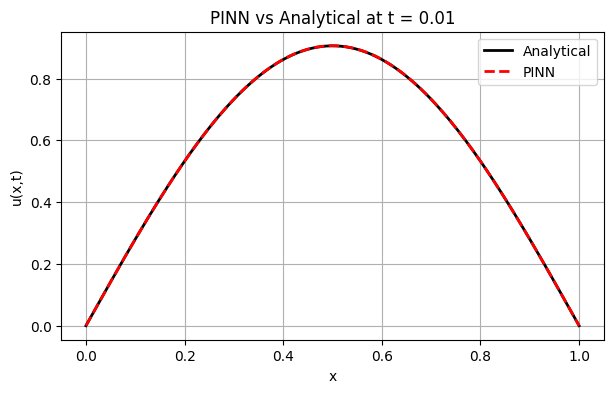

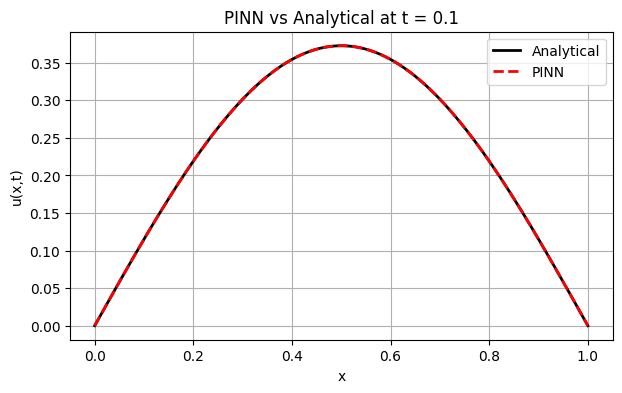

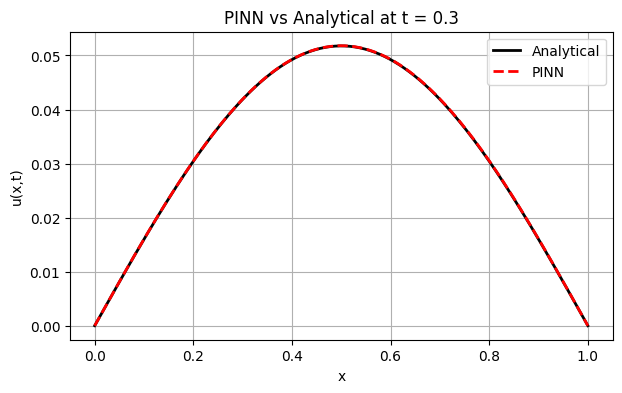

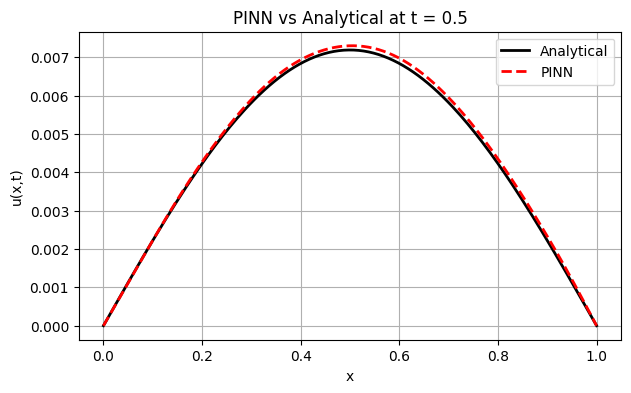

In [113]:


def pinn_solution(model, x, t_value):
    X_eval = np.stack([x, np.full_like(x, t_value)], axis=1).astype(np.float32)
    X_tf = tf.constant(X_eval, dtype=tf.float32)
    N_out = model(X_tf)
    return g_trial_tf(X_tf, N_out).numpy().flatten()

# Time slices for comparison
t_vals = [0.01, 0.10, 0.30, 0.50]
x = np.linspace(0, 1, 200)

for t_val in t_vals:
    u_pinn  = pinn_solution(model, x, t_val)
    u_exact = analytical_u(x, t_val)

    plt.figure(figsize=(7,4))
    plt.plot(x, u_exact, 'k-', lw=2, label='Analytical')
    plt.plot(x, u_pinn, 'r--', lw=2, label='PINN')
    plt.title(f"PINN vs Analytical at t = {t_val}")
    plt.xlabel("x")
    plt.ylabel("u(x,t)")
    plt.legend()
    plt.grid(True)
    plt.show()


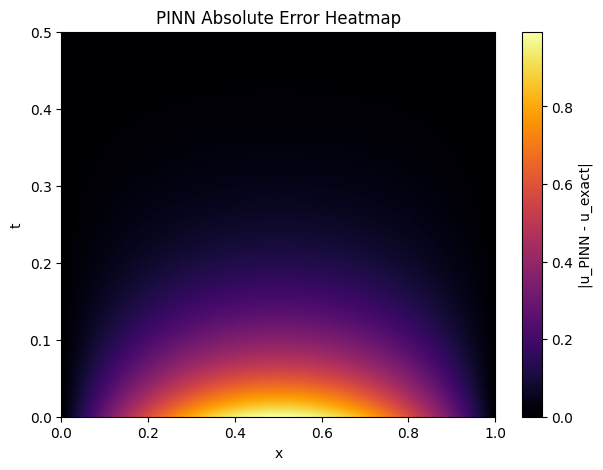

In [114]:
nx, nt = 200, 200
x = np.linspace(0, 1, nx)
t = np.linspace(0, 0.5, nt)
X, T = np.meshgrid(x, t)

X_flat = X.reshape(-1,1).astype(np.float32)
T_flat = T.reshape(-1,1).astype(np.float32)
X_input = np.hstack([X_flat, T_flat])

X_tf = tf.constant(X_input, dtype=tf.float32)
N_out = model(X_tf)
u_pinn = pinn_solution(model, x, t_val)
u_exact = analytical_u(X, T)

error = np.abs(u_pinn - u_exact)

plt.figure(figsize=(7,5))
plt.imshow(error, extent=[0,1,0,0.5], origin='lower', aspect='auto', cmap='inferno')
plt.colorbar(label="|u_PINN - u_exact|")
plt.xlabel("x")
plt.ylabel("t")
plt.title("PINN Absolute Error Heatmap")
plt.show()


In [115]:
def plot_all(x, t_grid, U, t_target, model, title):
    n_idx = np.argmin(np.abs(t_grid - t_target))
    u_euler = U[n_idx]
    u_exact = analytical_u(x, t_target)
    u_pinn  = pinn_solution(model, x, t_target)

    plt.figure(figsize=(7,4))
    plt.plot(x, u_exact, 'k-', lw=2, label="Analytical")
    plt.plot(x, u_euler, 'o', label="Euler FD")
    plt.plot(x, u_pinn, '-', label="PINN")
    plt.xlabel("x")
    plt.ylabel("u")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()


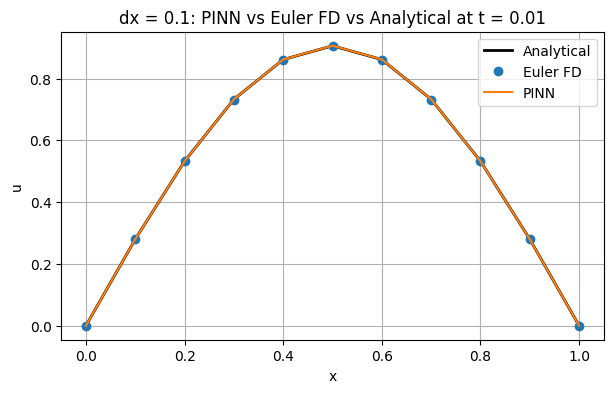

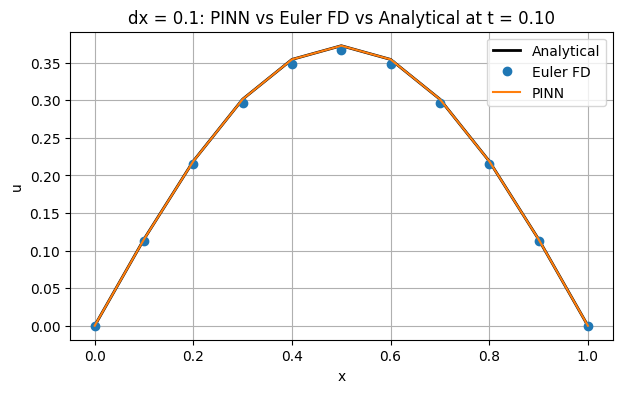

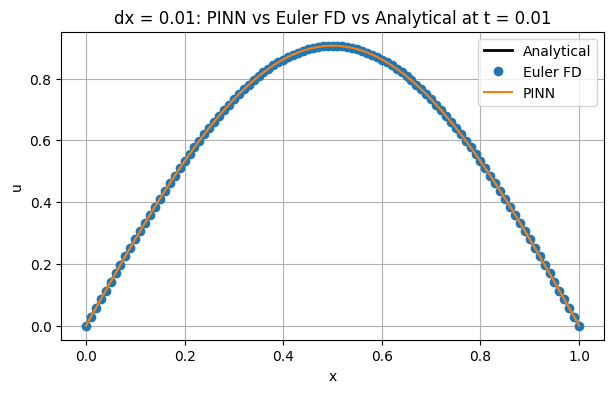

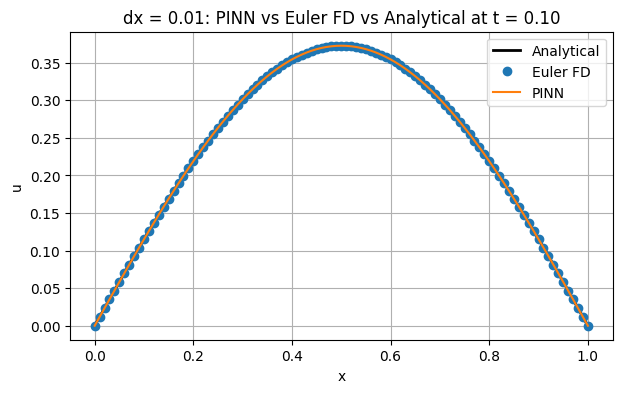

In [116]:

dx1 = 0.1
dt1 = 0.005        # stability limit: dt = dx^2 / 2 = 0.005
x1, t1, U1 = euler(dx1, dt1, T=0.2)

# Case 2: dx = 0.01
dx2 = 0.01
dt2 = 0.00005        # stability limit: dt = dx^2 / 2 = 5e-5
x2, t2, U2 = euler(dx2, dt2, T=0.2)

t1_val, t2_val = 0.01, 0.10   # or any times you like

plot_all(x1, t1, U1, t1_val, model,
         "dx = 0.1: PINN vs Euler FD vs Analytical at t = 0.01")
plot_all(x1, t1, U1, t2_val, model,
         "dx = 0.1: PINN vs Euler FD vs Analytical at t = 0.10")

plot_all(x2, t2, U2, t1_val, model,
         "dx = 0.01: PINN vs Euler FD vs Analytical at t = 0.01")
plot_all(x2, t2, U2, t2_val, model,
         "dx = 0.01: PINN vs Euler FD vs Analytical at t = 0.10")


In [117]:
def plot_long_time(x, U, t_grid, t_target, NN_model):
    idx = np.argmin(np.abs(t_grid - t_target))
    t_val = t_grid[idx]

    # Solutions
    u_exact = analytical_u(x, t_val)
    u_euler = U[idx]
    u_pinn  = pinn_solution(NN_model, x, t_val)

    # Plot
    plt.figure(figsize=(7,4))
    plt.plot(x, u_exact, 'k-', lw=2, label=f"Analytical t={t_val:.3f}")
    plt.plot(x, u_euler, 'o-', lw=1.5, label=f"Euler t={t_val:.3f}")
    plt.plot(x, u_pinn, '--', lw=2, label=f"PINN t={t_val:.3f}")

    plt.xlabel("x")
    plt.ylabel("u(x,t)")
    plt.title("Long-Time Comparison: Euler vs PINN vs Analytical")
    plt.grid(True)
    plt.legend()
    plt.show()


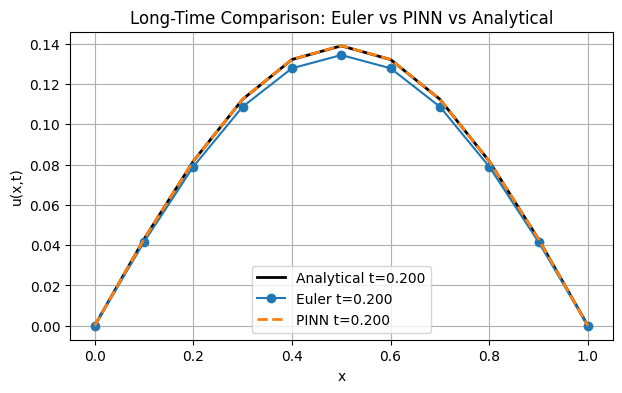

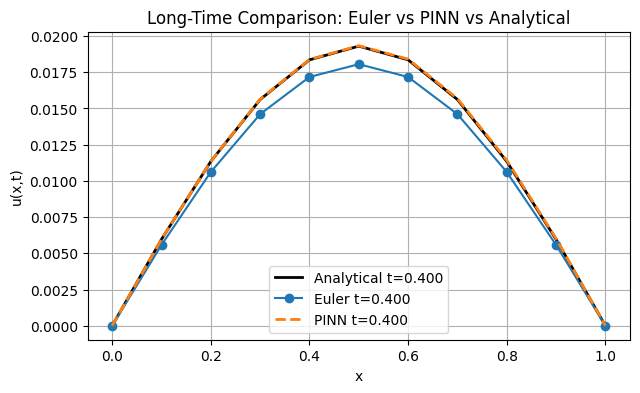

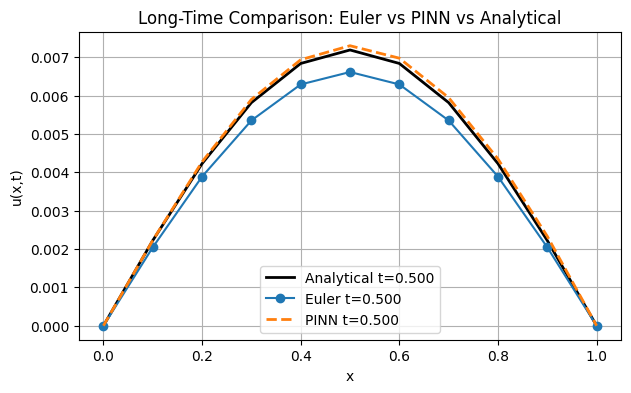

In [118]:
x1, t1, U1 = euler(dx1, dt1, T=T_final)

plot_long_time(x1, U1, t1, t_target=0.2, NN_model=model)
plot_long_time(x1, U1, t1, t_target=0.4, NN_model=model)
plot_long_time(x1, U1, t1, t_target=T_final, NN_model=model)